# Demand forecasting using Neural Networks in Google Colab

**Importing libraries - Tensorflow, Pandas, Matplotlib etc.**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Importing data from Google drive, and appending table headers

In [ ]:
dataset_path = "/content/drive/My Drive/Submission/OPM/OPMdata.xlsx"
dataset_path

column_names = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','Y']
raw_dataset = pd.read_excel(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,Y
54,56,0,0,0,0,0,0,0,1,0,0,0,0,1591
55,57,0,0,0,0,0,0,0,0,1,0,0,0,471
56,58,0,0,0,0,0,0,0,0,0,1,0,0,300
57,59,0,0,0,0,0,0,0,0,0,0,1,0,300
58,60,0,0,0,0,0,0,0,0,0,0,0,1,283


# Selecting training and test data, and indicating dependent variable

In [ ]:
train_dataset = dataset.iloc[0:46]
test_dataset = dataset.iloc[47:60]

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("Y")
train_stats = train_stats.transpose()

In [ ]:
train_labels = train_dataset.pop('Y')
test_labels = test_dataset.pop('Y')

# Normalizing data

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_test_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
47,1.825277,3.744561,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.261248
48,1.899778,-0.261248,3.204955,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.261248
49,1.974280,-0.261248,-0.305234,3.204955,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.261248
50,2.048781,-0.261248,-0.305234,-0.305234,3.204955,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.261248
51,2.123282,-0.261248,-0.305234,-0.305234,-0.305234,3.204955,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.261248
52,2.197783,-0.261248,-0.305234,-0.305234,-0.305234,-0.305234,3.204955,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.261248
53,2.272284,-0.261248,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,3.204955,-0.305234,-0.305234,-0.305234,-0.305234,-0.261248
54,2.346785,-0.261248,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,3.204955,-0.305234,-0.305234,-0.305234,-0.261248
55,2.421286,-0.261248,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,3.204955,-0.305234,-0.305234,-0.261248
56,2.495787,-0.261248,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,-0.305234,3.204955,-0.305234,-0.261248


#Neural network with two fully connected hidden layers, each with 64 nodes.
**The model uses RMSprop optimizer for optimizing by minimizing Mean Squared Error loss.**

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
......................................................................

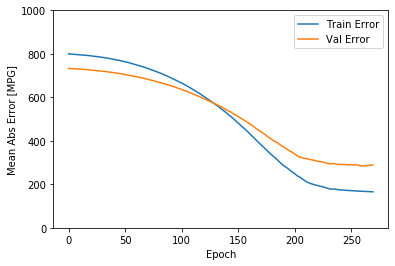

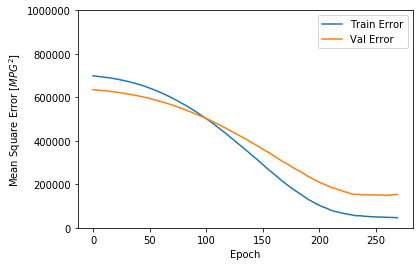

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,1000])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,1000000])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

12/12 - 0s - loss: 260316.9219 - mae: 377.5327 - mse: 260316.9219
Testing set Mean Abs Error: 377.53 MPG


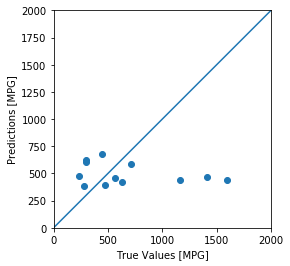

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


**Prediction**

In [ ]:
test_predictions

array([478.2986 , 424.98697, 583.36346, 461.38846, 464.08316, 676.104  ,
       442.115  , 442.90518, 397.4471 , 620.42615, 602.6929 , 382.1599 ],
      dtype=float32)

**Reference: This work contains code snippets from https://www.tensorflow.org/tutorials/keras/regression**